In [12]:
%matplotlib inline
#import Oscilloscope
import time
import Waveform
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from glob import glob
import pickle
import matplotlib.dates as md
import datetime as dt
import time
from matplotlib.gridspec import GridSpec
import zipfile
import datetime
import gc
import json

In [13]:
# settings
#path_to_data = "D:\\data_from_zip_20180329.pkl"
#path_to_data = "D:\\data_from_zip_20180320.pkl"
#path_to_data = "D:\\data_from_zip_20180329-new.pkl"
path_to_data = "C:/Users/Hendrik/OneDrive/active_sync_storage/Uni/MPIK/Bachelor/MPIKLabSoftware/LeCroyHDO/data_from_zip_20180331_new.json"
data_suffix = "{}_".format(path_to_data.split('_')[-1].split('.')[0])

plot_dir = "with_time_cut_"
plot_dir = "C:\\Users\\Hendrik\\OneDrive\\active_sync_storage\\Uni\\MPIK\\Bachelor\\Teilchenwelt_detector\\plot_save\\thesis_plots\\"
#plot_dir += data_suffix

smoothing_window = [32, 4096*4, 4096*4]

In [14]:
with open(path_to_data, 'r') as f:
    WF_data = json.load(f)

for key in WF_data.keys():
    WF_data[key] = np.asarray(WF_data[key])

In [15]:
# extract the modes and channels
modes = []
channels_to_read = []
for key in WF_data.keys():
    if key == 'unixtime' or key == 'CosMO coincidence' or key == 'name_prefix':
        continue
    mode = key.split('_')[1]
    if mode not in modes:
        modes.append(mode)
    
    chan = key.split('_')[0]
    if chan not in channels_to_read:
        channels_to_read.append(chan)

print(channels_to_read, modes, plot_dir)

['C2', 'C1', 'C3'] ['diff2', 'diff1', 'raw'] C:\Users\Hendrik\OneDrive\active_sync_storage\Uni\MPIK\Bachelor\Teilchenwelt_detector\plot_save\thesis_plots\


In [16]:
# parse prefix

key = 'name_prefix'
WF_data['source'] = np.empty_like(WF_data[key], dtype=np.bool)
WF_data['lead'] = np.empty_like(WF_data[key], dtype=np.bool)
WF_data['AC'] = np.empty_like(WF_data[key], dtype=np.bool)

for i in range(len(WF_data[key])):
    prefix = WF_data[key][i]
    split_prefix = prefix.split('-')
    
    if 'NO' in split_prefix[0]:
        WF_data['source'][i] = False
    else:
        WF_data['source'][i] = True
    
    if 'NO' in split_prefix[1]:
        WF_data['lead'][i] = False
    else:
        WF_data['lead'][i] = True
    
    if 'AC' not in split_prefix[3]:
        WF_data['AC'][i] = False
    else:
        WF_data['AC'][i] = True

In [20]:
print("\t\tsource-lead\tNOsource-lead\tNOsource-NOlead")
for AC_mode in [True, False]:
    trig = 'DC'
    if AC_mode:
        trig = 'AC'
    source_lead = np.sum((WF_data['source'] == True) & (WF_data['lead'] == True) & (WF_data['AC'] == AC_mode))
    NOsource_lead = np.sum((WF_data['source'] == False) & (WF_data['lead'] == True) & (WF_data['AC'] == AC_mode))
    NOsource_NOlead = np.sum((WF_data['source'] == False) & (WF_data['lead'] == False) & (WF_data['AC'] == AC_mode))
    print("Trigger {}:\t{}\t\t{}\t\t{}".format(trig, source_lead, NOsource_lead, NOsource_NOlead))

		source-lead	NOsource-lead	NOsource-NOlead
Trigger AC:	281		11		18
Trigger DC:	415		42		38


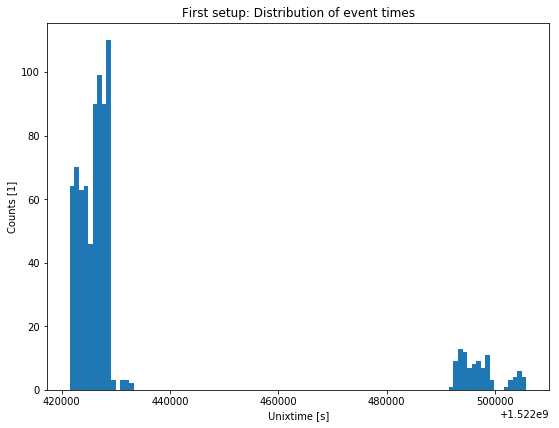

In [10]:
# plot the distribution of events in time
bins = 100
size_factor = 0.75

# convert timestamps into for matplotlib readable time
#dates = [datetime.fromtimestamp(ts) for ts in WF_data['unixtime']]

fig, axarr = plt.subplots(1, sharex=False)
axarr = (axarr,)
fig.set_size_inches(size_factor*9*4./3., size_factor*9*1)
axarr[0].hist(WF_data['unixtime'], bins)
axarr[0].set_ylabel("Counts [1]")
axarr[0].set_xlabel("Unixtime [s]")
axarr[0].set_title('First setup: Distribution of event times')

#axarr[1].hist(WF_data['unixtime'], bins)
#axarr[1].set_ylabel("Counts [1]")
#axarr[1].set_xlabel("Unixtime [s]")
#axarr[1].set_title('Second setup: Distribution of event times')

plt.savefig(plot_dir+"Distro_of_event_times_size-{}.pdf".format(size_factor))
plt.show()


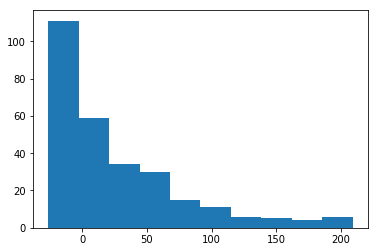

In [24]:
bins = 10
chan = 'C3'
mode = 'raw'

source_lead_mask = (WF_data['source'] == True) & (WF_data['lead'] == True) & (WF_data['AC'] == True)
NOsource_lead_mask = (WF_data['source'] == False) & (WF_data['lead'] == True) & (WF_data['AC'] == True)
NOsource_NOlead_mask = (WF_data['source'] == False) & (WF_data['lead'] == False) & (WF_data['AC'] == True)

plt.hist(WF_data['{}_{}_max'.format(chan, mode)][source_lead_mask], bins=bins)


plt.show()

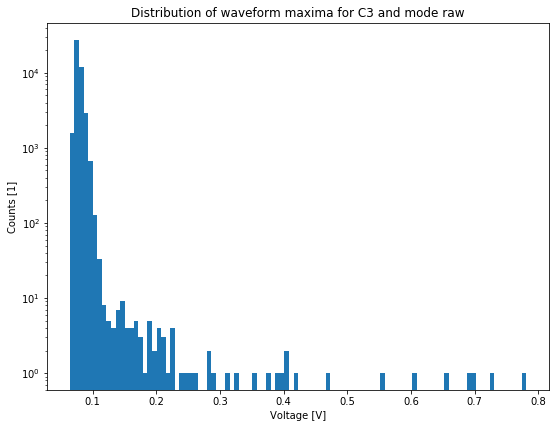

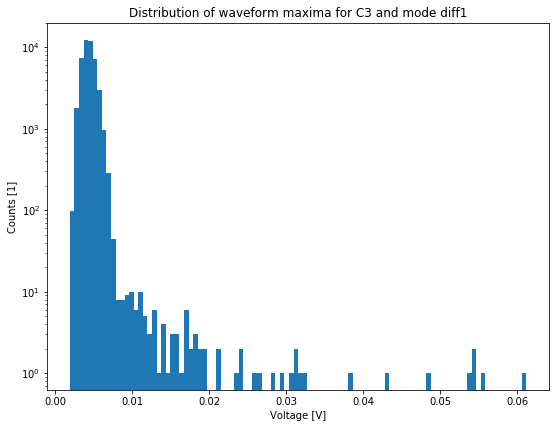

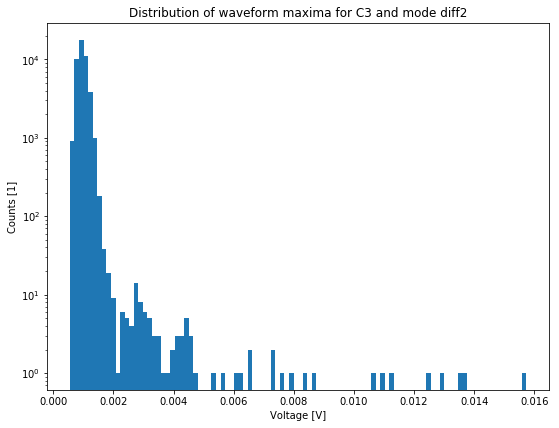

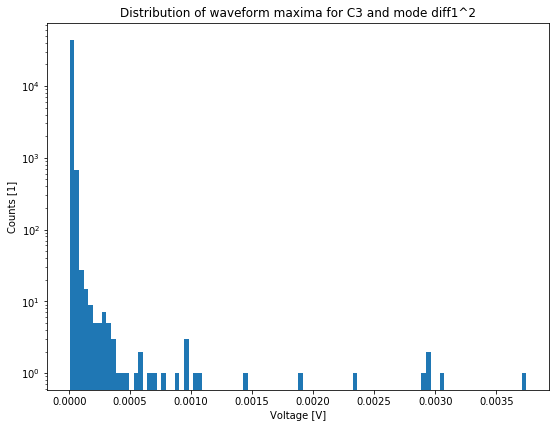

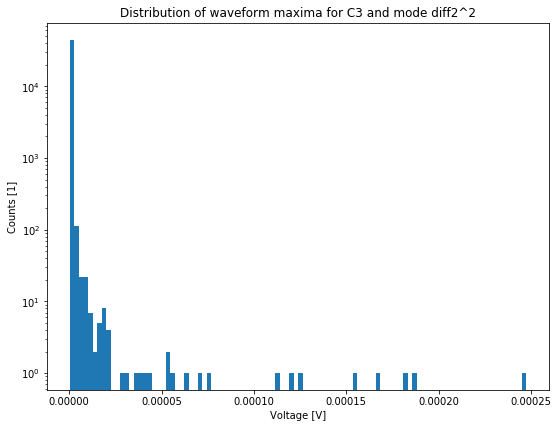

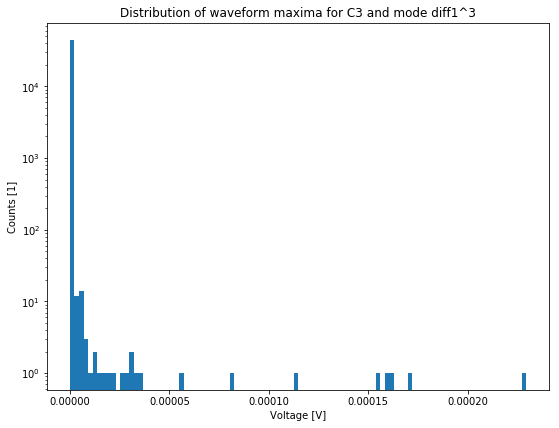

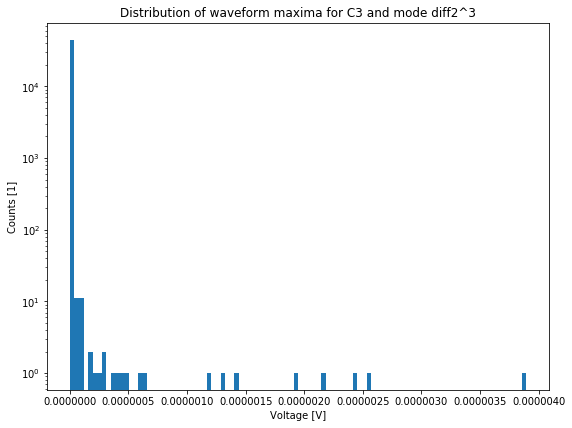

In [82]:
# plot the distribution of maxima
bins = 100
size_factor = 0.75

chan = channels_to_read[0]
for mode in modes:
    for chan in channels_to_read:
        if chan in ['C1', 'C2']:
            continue
        fig, ax = plt.subplots()
        fig.set_size_inches(size_factor*9*4./3., size_factor*9)
        plt.hist(WF_data['{}_{}_max'.format(chan, mode)], bins)
        plt.yscale('log', nonposy='clip')
        plt.ylabel("Counts [1]")
        plt.xlabel("Voltage [V]")
        plt.title('Distribution of waveform maxima for {} and mode {}'.format(chan, mode))
        #plt.savefig(plot_dir+"Distro_of_peaks_ch{}_size-{}.png".format(chan, size_factor))
        plt.show()

In [110]:
# calculate coincidences
coincidence_window_CosMO = 10 * 10 ** (-6) # 10 us
thresh_CosMO = 20 * 10**(-3) # 20 mV

WF_data['CosMO coincidence'] = np.zeros_like(WF_data['{}_{}_max'.format(chan, mode)], dtype=bool)

# check where both CosMO channels are above threshold
chan = 'C1'
chan2 = 'C2'
pin_chan = 'C3'
events_above_thresh = np.where((WF_data[chan+'_raw_max'] > thresh_CosMO) &  (WF_data[chan2+'_raw_max'] > thresh_CosMO))[0]
# check that for each above threshold event the events are with in the coincidence window
for i in events_above_thresh:
    time_diff = abs(WF_data[chan+'_raw_max_time'][i] - WF_data[chan2+'_raw_max_time'][i])
    if time_diff <= coincidence_window_CosMO:
        # check that the PIN diode is behind the CosMO detector, otherwise the causality would not match
        if WF_data[pin_chan+'_raw_max_time'][i] > WF_data[chan+'_raw_max_time'][i]:
            WF_data['CosMO coincidence'][i] = True

cosmo_coincidence_indexes = np.where(WF_data['CosMO coincidence'] == True)[0]
len(cosmo_coincidence_indexes)

107

([array([  5.,   2.,   3.,   3.,   1.,   1.,   4.,   5.,   1.,   3.,   2.,
           3.,   8.,   5.,   9.,   9.,   8.,  10.,  11.,   3.,   0.,   3.,
           5.,   2.,   0.,   0.,   1.,   0.,   0.,   0.]),
  array([  5.,   2.,   3.,   3.,   1.,   1.,   4.,   5.,   1.,   3.,   2.,
           3.,   8.,   5.,   9.,   9.,   8.,  10.,  11.,   3.,   1.,  20.,
          22.,  21.,  15.,  10.,   4.,  12.,   9.,   4.])],
 array([ 0.00060432,  0.00063205,  0.00065979,  0.00068752,  0.00071525,
         0.00074298,  0.00077072,  0.00079845,  0.00082618,  0.00085392,
         0.00088165,  0.00090938,  0.00093711,  0.00096485,  0.00099258,
         0.00102031,  0.00104805,  0.00107578,  0.00110351,  0.00113124,
         0.00115898,  0.00118671,  0.00121444,  0.00124218,  0.00126991,
         0.00129764,  0.00132538,  0.00135311,  0.00138084,  0.00140857,
         0.00143631]),
 <a list of 2 Lists of Patches objects>)

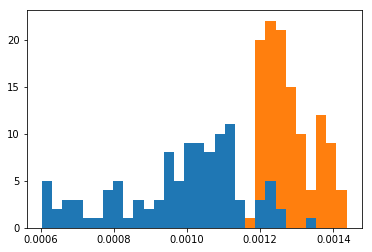

In [125]:
cosmo_coincidence_indexes
plt.hist([WF_data['C2_raw_max_time'][cosmo_coincidence_indexes], WF_data['C3_raw_max_time'][cosmo_coincidence_indexes]],stacked=True, bins=30)

In [111]:
mode = modes[2]
def get_unit_for_mode(mode):
    if 'raw' in mode:
        unit = '[V]'
    else:
        upper_exp = 1
        lower_exp = 0
        if 'diff' in mode:
            num_abl = int(mode.split('iff')[1][0])
            lower_exp += num_abl
            if '^' in mode:
                num_exp = int(mode.split('^')[1][0])
                upper_exp += num_exp-1
                lower_exp += num_exp-1

        if upper_exp == 1:
            upper_exp = ''
        else:
            upper_exp = '^{}'.format(upper_exp)
        if lower_exp == 1:
            lower_exp = ''
        else:
            lower_exp = '^{}'.format(lower_exp)
        
        unit = "[$V{} / s{}$]".format(upper_exp, lower_exp)
    return unit

get_unit_for_mode(mode)

'[$V / s^2$]'

In [116]:
threshholds['raw'][number_PIN_tiggers['raw'] == number_PIN_tiggers['raw'][0]]

array([ 0.        ,  0.00781464,  0.01562929,  0.02344393,  0.03125858,
        0.03907322,  0.04688786,  0.05470251,  0.06251715])

C:\Users\Hendrik\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel\__main__.py:33: RuntimeWarning: invalid value encountered in true_divide


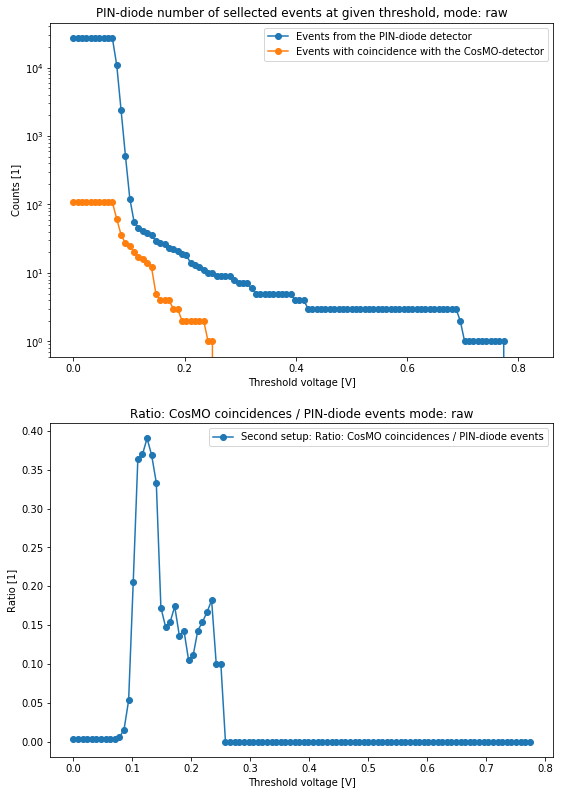

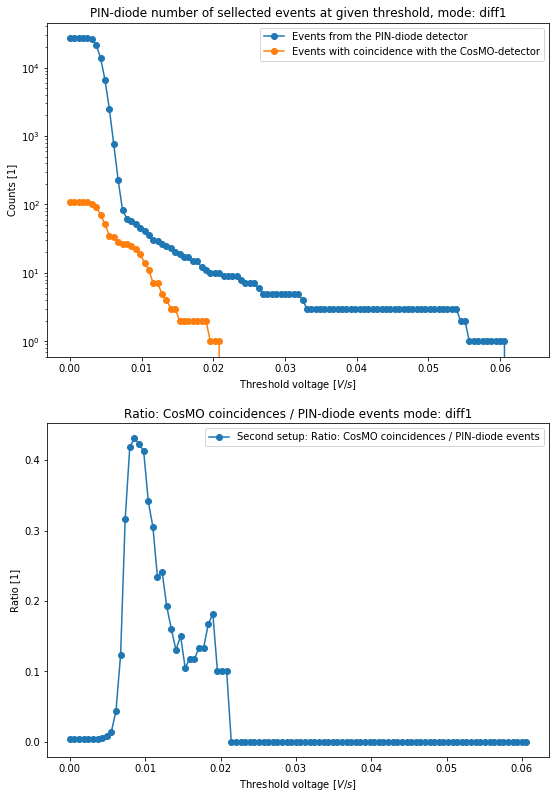

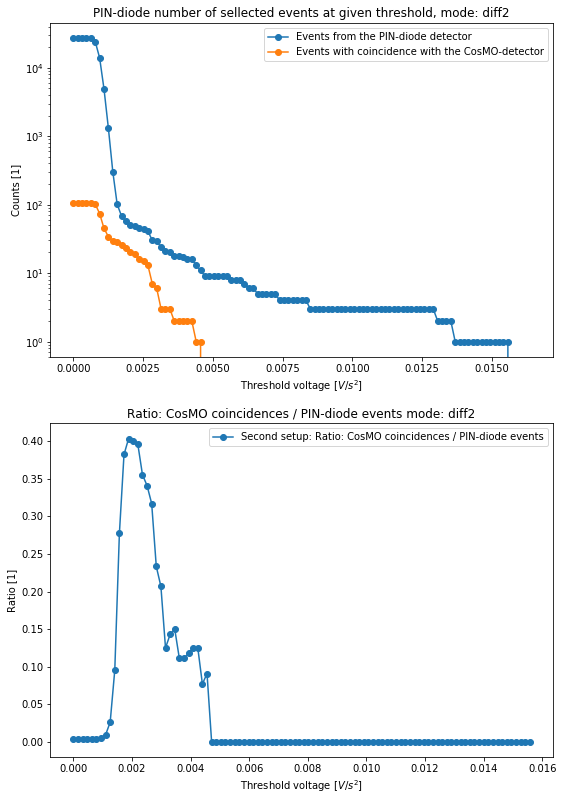

In [112]:
# plot the number of tirggered PIN-diode events against the coincidences at the CosMO-detector
pin_chan = 'C3'
size_factor = 0.75

threshholds = {m: np.arange(0, 1.05*WF_data["C3_{}_max".format(m)].max(), 0.01*WF_data["C3_{}_max".format(m)].max()) for m in modes}
number_PIN_tiggers = {key: np.empty_like(threshholds[key]) for key in modes}
number_CosMO_coincidences = {key: np.empty_like(threshholds[key]) for key in modes}

# scan a threshold regions
for mode in modes:
    for i in range(len(threshholds[mode])):
        thresh = threshholds[mode][i]
        indexes_above_thresh = np.where(WF_data['{}_{}_max'.format(pin_chan, mode)] > thresh)
        number_PIN_tiggers[mode][i] = len(indexes_above_thresh[0])
        cosmo_coince_data = WF_data['CosMO coincidence'][indexes_above_thresh]
        number_CosMO_coincidences[mode][i] = np.sum(cosmo_coince_data == True)

# plot the collected data
for mode in modes:
    fig, ax = plt.subplots(2, sharex=False)
    fig.set_size_inches(size_factor*9*4./3., size_factor*9*2)
    ax[0].errorbar(threshholds[mode], number_PIN_tiggers[mode], fmt='-o', label='Events from the PIN-diode detector')
    ax[0].errorbar(threshholds[mode], number_CosMO_coincidences[mode], fmt='-o', label='Events with coincidence with the CosMO-detector')
    ax[0].set_yscale('log')
    ax[0].set_xlabel("Threshold voltage {}".format(get_unit_for_mode(mode)))
    ax[0].set_ylabel("Counts [1]")
    ax[0].set_title('PIN-diode number of sellected events at given threshold, mode: {}'.format(mode))
    ax[0].legend()
    #plt.savefig(plot_dir+"Triggered_events_pin_and_cosmo_size-{}.pdf".format(size_factor))
    #plt.show()

    # plot the ratio between the two curves
    ratio_data = number_CosMO_coincidences[mode] / number_PIN_tiggers[mode]

    #fig, ax = plt.subplots()
    #fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    ax[1].errorbar(threshholds[mode], ratio_data, fmt='-o', label='Second setup: Ratio: CosMO coincidences / PIN-diode events')
    ax[1].set_xlabel("Threshold voltage {}".format(get_unit_for_mode(mode)))
    ax[1].set_ylabel("Ratio [1]")
    ax[1].set_title('Ratio: CosMO coincidences / PIN-diode events mode: {}'.format(mode))
    ax[1].legend()
    plt.savefig(plot_dir+"threshold_scan_mode_{}_size-{}.pdf".format(mode, size_factor))
    plt.show()

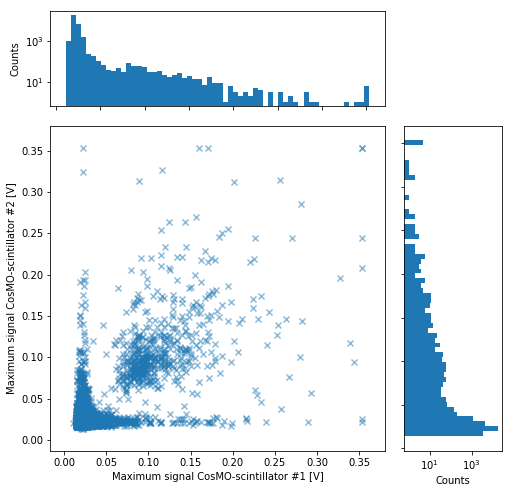

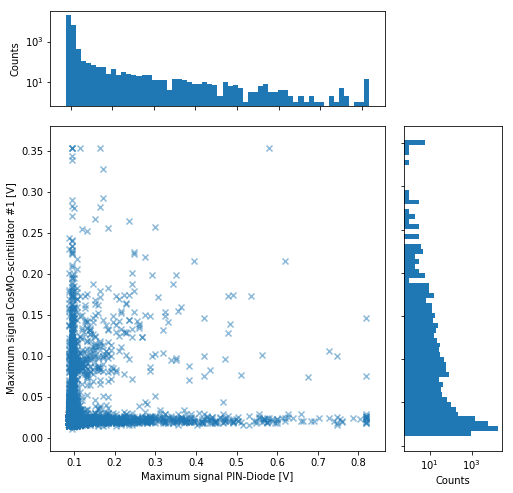

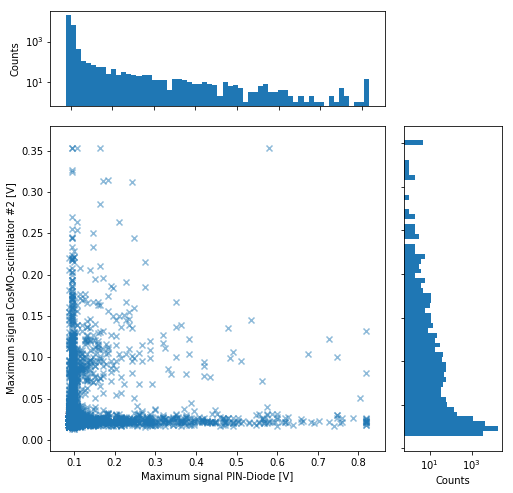

In [160]:
size_factor = 0.9
num_bins = 60

x = WF_data['C1_max']
y = WF_data['C2_max']

# correllation plots
fig = plt.figure(1, figsize=(size_factor*9, size_factor*9))
gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x,y, alpha=0.5, marker='x')
ax_marg_x.hist(x, bins=num_bins)
ax_marg_y.hist(y,orientation="horizontal", bins=num_bins)

# set scaling
ax_marg_x.set_yscale('log', nonposy='clip')
ax_marg_y.set_xscale('log')

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Maximum signal CosMO-scintillator #1 [V]')
ax_joint.set_ylabel('Maximum signal CosMO-scintillator #2 [V]')

# Set labels on marginals
ax_marg_y.set_xlabel('Counts')
ax_marg_x.set_ylabel('Counts')

plt.savefig(plot_dir+"scatter_plot_C1_max_vs_C2_max_size-{}.pdf".format(size_factor))
plt.show()


for i in range(1, 3):
    
    x = WF_data['C3_max']
    y = WF_data['C{}_max'.format(i)]

    # correllation plots
    fig = plt.figure(1, figsize=(size_factor*9, size_factor*9))
    gs = GridSpec(4,4)

    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])

    ax_joint.scatter(x,y, alpha=0.5, marker='x')
    ax_marg_x.hist(x, bins=num_bins)
    ax_marg_y.hist(y, orientation="horizontal", bins=num_bins)

    # set scaling
    ax_marg_x.set_yscale('log', nonposy='clip')
    ax_marg_y.set_xscale('log')

    # Turn off tick labels on marginals
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel("Maximum signal PIN-Diode [V]")
    ax_joint.set_ylabel("Maximum signal CosMO-scintillator #{} [V]".format(i))

    # Set labels on marginals
    ax_marg_y.set_xlabel('Counts')
    ax_marg_x.set_ylabel('Counts')

    plt.savefig(plot_dir+"scatter_plot_C3_max_vs_C{}_max_size-{}.pdf".format(i, size_factor))
    plt.show()

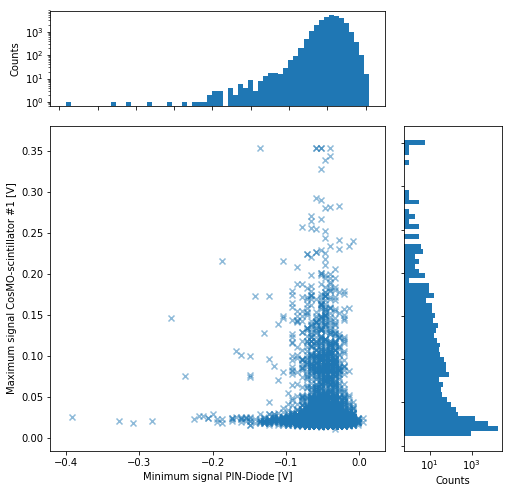

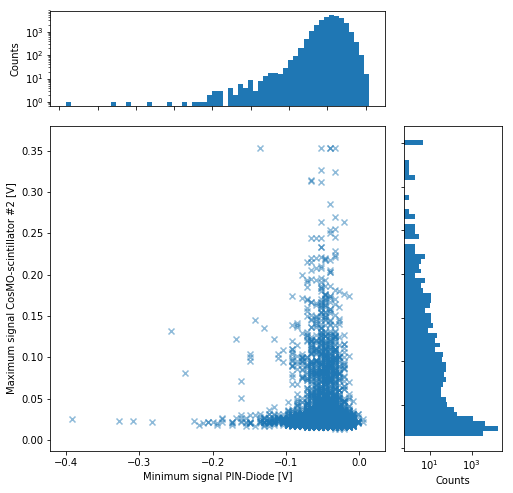

In [161]:
size_factor = 0.9
num_bins = 60

for i in range(1, 3):
    x = WF_data['C3_min']
    y = WF_data['C{}_max'.format(i)]

    # correllation plots
    fig = plt.figure(1, figsize=(size_factor*9, size_factor*9))
    gs = GridSpec(4,4)

    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])

    ax_joint.scatter(x,y, alpha=0.5, marker='x')
    ax_marg_x.hist(x, bins=num_bins)
    ax_marg_y.hist(y,orientation="horizontal", bins=num_bins)

    # set scaling
    ax_marg_x.set_yscale('log', nonposy='clip')
    ax_marg_y.set_xscale('log')

    # Turn off tick labels on marginals
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel("Minimum signal PIN-Diode [V]")
    ax_joint.set_ylabel("Maximum signal CosMO-scintillator #{} [V]".format(i))

    # Set labels on marginals
    ax_marg_y.set_xlabel('Counts')
    ax_marg_x.set_ylabel('Counts')

    plt.savefig(plot_dir+"scatter_plot_C3_min_vs_C{}_max_size-{}.pdf".format(i, size_factor))
    plt.show()


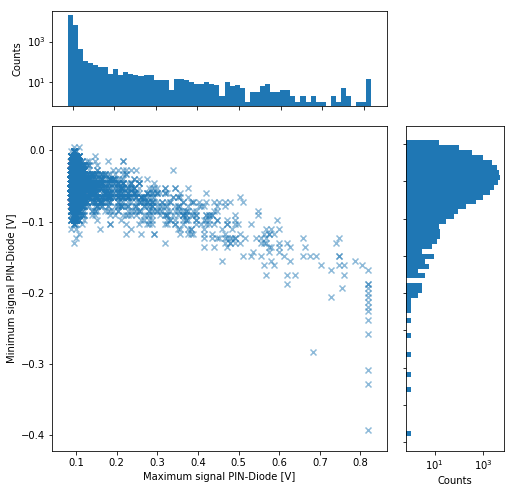

In [162]:
size_factor = 0.9
num_bins = 60

x = WF_data['C3_max']
y = WF_data['C3_min']

# correllation plots
fig = plt.figure(1, figsize=(size_factor*9, size_factor*9))
gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x,y, alpha=0.5, marker='x')
ax_marg_x.hist(x, bins=num_bins)
ax_marg_y.hist(y,orientation="horizontal", bins=num_bins)

# set scaling
ax_marg_x.set_yscale('log', nonposy='clip')
ax_marg_y.set_xscale('log')

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_ylabel('Minimum signal PIN-Diode [V]')
ax_joint.set_xlabel('Maximum signal PIN-Diode [V]')

# Set labels on marginals
ax_marg_y.set_xlabel('Counts')
ax_marg_x.set_ylabel('Counts')

plt.savefig(plot_dir+"scatter_plot_C3_max_vs_C3_min_size-{}.pdf".format(size_factor))
plt.show()

In [15]:
WF_data

{'C1_max': array([ 0.02360001,  0.02200001,  0.0204    , ...,  0.01880001,
         0.01880001,  0.02200001], dtype=float32),
 'C1_max_time': array([ 0.00173443,  0.0012298 ,  0.00111558, ...,  0.00192283,
         0.00170238,  0.00143174], dtype=float32),
 'C1_min': array([-0.00519998, -0.00519998, -0.00519998, ..., -0.00519998,
        -0.00359999, -0.00519998], dtype=float32),
 'C1_min_time': array([ 0.00074066,  0.00080274,  0.00133178, ...,  0.00060488,
         0.00060426,  0.00072851], dtype=float32),
 'C2_max': array([ 0.0204    ,  0.02680001,  0.02360001, ...,  0.02840001,
         0.01720001,  0.0204    ], dtype=float32),
 'C2_max_time': array([ 0.00219235,  0.00063921,  0.00115562, ...,  0.00132581,
         0.00141088,  0.0019409 ], dtype=float32),
 'C2_min': array([-0.00519998, -0.00519998, -0.00519998, ..., -0.00519998,
        -0.00519998, -0.00519998], dtype=float32),
 'C2_min_time': array([ 0.00062501,  0.00066804,  0.00061047, ...,  0.00061379,
         0.00068309,  0

In [8]:
# select events that were after the PIN-Diode
first_coincidence = WF_data['C1_max_time'] > WF_data[pin_chan+'_max_time']
first_coincidence_2 = WF_data['C1_max_time'] < WF_data[pin_chan+'_max_time']

second_coincidence = WF_data['C2_max_time'] > WF_data[pin_chan+'_max_time']
second_coincidence_2 = WF_data['C2_max_time'] < WF_data[pin_chan+'_max_time']


# put both together
PIN_before_cosmo = first_coincidence & second_coincidence
print(np.sum(PIN_before_cosmo))
PIN_after_cosmo = first_coincidence_2 & second_coincidence_2
print(np.sum(PIN_after_cosmo))

# check for actual coincidence worthy signals
cosmo_high1 = WF_data['C1_max'] > thresh_CosMO
cosmo_high2 = WF_data['C2_max'] > thresh_CosMO
cosmi_high_combined = cosmo_high1 & cosmo_high2
print(np.sum(cosmo_high1), np.sum(cosmo_high2), np.sum(cosmi_high_combined))
cosmo_timing_ok = np.abs(WF_data['C1_max_time'] - WF_data['C2_max_time']) < coincidence_window_CosMO
cosmo_high_time_combined = cosmi_high_combined & cosmo_timing_ok
print(np.sum(cosmo_timing_ok), np.sum(cosmo_high_time_combined))

# combine before cosmo and actual coincidences in C1 and C2
PIN_before_cosmo_and_event = cosmo_high_time_combined & PIN_before_cosmo
print(np.sum(PIN_before_cosmo_and_event))
PIN_after_cosmo_and_event = cosmo_high_time_combined & PIN_after_cosmo
print(np.sum(PIN_after_cosmo_and_event))

# combine without checking proximity
PIN_before_cosmo_both_high = PIN_before_cosmo & (cosmo_high1 & cosmo_high2)
PIN_after_cosmo_both_high = PIN_after_cosmo & (cosmo_high1 & cosmo_high2)
print(np.sum(PIN_before_cosmo_both_high), np.sum(PIN_after_cosmo_both_high))

11398
4056
19437 24902 17192
583 573
204
369
7429 2327


In [9]:
len(WF_data['C1_max_time'])

28315

In [12]:
# select where we have no coincidences
no_coincidence_mask = WF_data['CosMO coincidence'] == False
print(np.sum(no_coincidence_mask))
# get the threshold with the maximum counts (minus one step)
best_thresh = threshholds[np.where(ratio_data == np.nanmax(ratio_data))[0] - 1]
# select where the we are above the threshold
above_best_thresh_mask = WF_data[pin_chan+'_max'] > best_thresh
print(np.sum(above_best_thresh_mask))
# combine the two basks
comb_mask = no_coincidence_mask & above_best_thresh_mask
print(np.sum(comb_mask))

# get all timstamps where this is true
sellected_times = WF_data['unixtime'][np.where(comb_mask)]
print(len(sellected_times))

27946
927
722
722


In [35]:
path_to_zip = "Z:\\MPIK\\recordings_until_20180320.zip"
#zf = zipfile.ZipFile(path_to_zip, 'r')
#name_list = zf.namelist()

def extract_WFs_for_timestamp(timestamp):
    timestamp = str(timestamp)
    
    extracted_WFs = []
    # open the zip file
    with zipfile.ZipFile(path_to_zip, 'r') as zf:
        # get the list of files in the zip
        name_list = zf.namelist()
        
        # start the extraction process
        files_to_extract = []
        for name in name_list:
            if timestamp in name:
                files_to_extract.append(name)

        files_to_extract = sorted(files_to_extract)
        for name in files_to_extract:
            try:
                data = zf.read(name)
                extracted_WFs.append(Waveform.Waveform(data))
            except OSError as e:
                print("An OSError with the following message occured: {}".format(e))
                print("The that was to be extracted was: {}".format(name))
                print("Continuing anyways.")
        print(files_to_extract)
    return extracted_WFs

# test the function
WF_test = extract_WFs_for_timestamp(sellected_times[0])

# function to do a moving average over the data
def avg_smoother(y, width):
    window = np.ones(width)/width
    y_smooth = np.convolve(y, window, mode='same')
    return y_smooth

# function to reduce the array size by averaging over fixed parts
def avg_reducer(x, y, width):
    # see: https://stackoverflow.com/a/26639037
    x = x[:len(x)//width * width].reshape(-1, width).mean(axis=1)
    y = y[:len(y)//width * width].reshape(-1, width).mean(axis=1)
    return x, y

def plot_and_save_an_event(unix_timestamp):
    readable_time = datetime.datetime.fromtimestamp(unix_timestamp).strftime('%Y.%m.%d %H:%M:%S')
    
    WFs = extract_WFs_for_timestamp(unix_timestamp)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    for WF in WFs:
        WF.plot_waveform(ax)
    plt.ylabel("Voltage [V]")
    plt.xlabel("Time [s]")
    #x = np.arange(0, 0.003)
    #my_xticks = x*1000
    #plt.xticks(x, my_xticks)
    plt.legend()
    plt.title('Event at: {}'.format(readable_time))
    plt.savefig(plot_dir+"raw_event_plots\\raw_event_plot_at_{}.png".format(unix_timestamp), dpi=600)
    
    # instad of showing the plot just delete it directly
    plt.show()
    plt.close()
    return

['LeCroyHDO/measurement_1521233263_C1.bytes', 'LeCroyHDO/measurement_1521233263_C2.bytes', 'LeCroyHDO/measurement_1521233263_C3.bytes']


In [20]:
# plot the first few events
size_factor = 0.75
#num_events_to_plot = len(sellected_times)
start_event = 45
num_events_to_plot = 5

for i in range(start_event, start_event + num_events_to_plot):
    unix_timestamp = sellected_times[i]
    plot_and_save_an_event(unix_timestamp)
    print("Events plotted: {}".format(i+1))

Events plotted: 46
Events plotted: 47
Events plotted: 48
Events plotted: 49
Events plotted: 50


In [163]:
print(gc.collect(generation=2))

23447


No handles with labels found to put in legend.


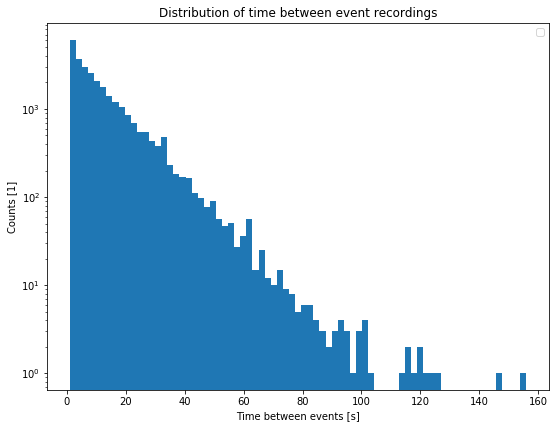

In [164]:
# time between events
bins = 75
size_factor = 0.75

diff_between_events = np.diff(sorted(WF_data['unixtime']))


fig, ax = plt.subplots()
fig.set_size_inches(size_factor*9*4./3., size_factor*9)
plt.hist(diff_between_events, bins)
plt.yscale('log', nonposy='clip')
plt.ylabel("Counts [1]")
plt.xlabel("Time between events [s]")
plt.legend()
plt.title('Distribution of time between event recordings')
plt.savefig(plot_dir+"Distro_of_time_between_events_size-{}.pdf".format(size_factor))
plt.show()

In [23]:
# json dump
WF_data_lists_1 = {}
WF_data_lists_2 = {}

for key in WF_data.keys():
    WF_data_lists_1[key] = WF_data_old[key].tolist()
    WF_data_lists_2[key] = WF_data[key].tolist()

with open(plot_dir+'WF_data_1.json', 'w') as outfile:
    json.dump(WF_data_lists_1, outfile)

with open(plot_dir+'WF_data_2.json', 'w') as outfile:
    json.dump(WF_data_lists_2, outfile)

In [37]:
# read data from michaels simulation
m_sim = np.genfromtxt('WF_simulation_low.txt', delimiter=';\t')

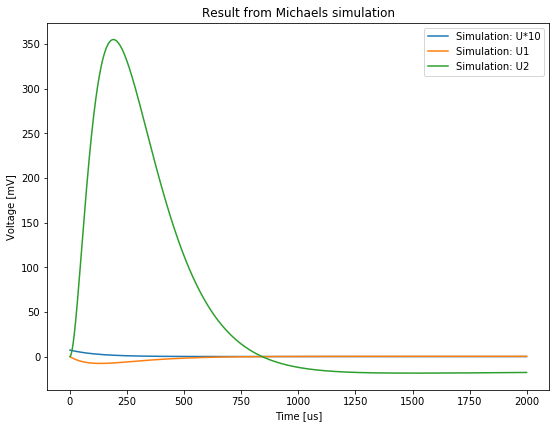

In [165]:
size_factor = 0.75

fig, ax = plt.subplots()
fig.set_size_inches(size_factor*9*4./3., size_factor*9)
plt.errorbar(m_sim[...,0], m_sim[...,1]*10, fmt='-', label='Simulation: U*10')
plt.errorbar(m_sim[...,0], m_sim[...,2], fmt='-', label='Simulation: U1')
plt.errorbar(m_sim[...,0], m_sim[...,3], fmt='-', label='Simulation: U2')
#plt.yscale('log')
plt.xlabel("Time [us]")
plt.ylabel("Voltage [mV]")
plt.title('Result from Michaels simulation')
plt.legend()
plt.savefig(plot_dir+"size_{}_simulation.pdf".format(size_factor))
plt.show()

In [86]:
tollerance_mV = 20.

# find WFs wich match
U2_max = m_sim[...,3].max()
U2_max = 80
voltage_mask = (WF_data['C3_max'] > (U2_max-tollerance_mV/2)/1000.) & (WF_data['C3_max'] < (U2_max+tollerance_mV)/1000.)
coincidence_and_voltage_mask = voltage_mask & (WF_data['CosMO coincidence'] == True)
no_coincidence_and_voltage_mask = voltage_mask & (WF_data['CosMO coincidence'] == False)
print(np.sum(voltage_mask), np.sum(coincidence_and_voltage_mask), np.sum(no_coincidence_and_voltage_mask))

mask_indices = np.where(voltage_mask)[0]

20600 86 20514


In [81]:
WF_data['unixtime'][voltage_mask]

array([1521224148, 1521323854, 1521471226, 1521293264, 1521533567,
       1521382621, 1521308190, 1521264153, 1521402842, 1521240568,
       1521431936, 1521488241, 1521350539, 1521488540, 1521421133,
       1521376458, 1521338566, 1521261796, 1521456573, 1521385423,
       1521226618, 1521237118, 1521431463, 1521214243, 1521395321,
       1521294850, 1521304405, 1521421066, 1521496682, 1521510079,
       1521280648, 1521425111, 1521391918, 1521354208, 1521344914,
       1521278695, 1521422889, 1521437203, 1521440028, 1521508797,
       1521464840, 1521328988, 1521496326, 1521453079, 1521197957,
       1521289425, 1521374268, 1521458321, 1521279723, 1521384698,
       1521229129, 1521513841, 1521346373, 1521300374, 1521294826,
       1521324046, 1521289830, 1521359004, 1521400835, 1521299511,
       1521403668, 1521489361, 1521507764, 1521536968, 1521472883,
       1521464906, 1521508017, 1521404140, 1521502446, 1521460340,
       1521328179, 1521454383, 1521381319, 1521238692, 1521431

['LeCroyHDO/measurement_1521256171_C1.bytes', 'LeCroyHDO/measurement_1521256171_C2.bytes', 'LeCroyHDO/measurement_1521256171_C3.bytes']


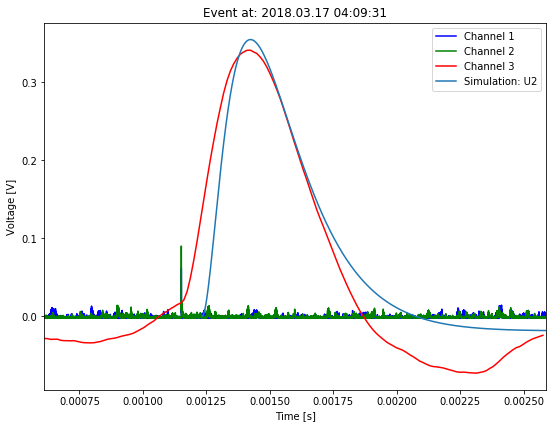

['LeCroyHDO/measurement_1521519865_C1.bytes', 'LeCroyHDO/measurement_1521519865_C2.bytes', 'LeCroyHDO/measurement_1521519865_C3.bytes']


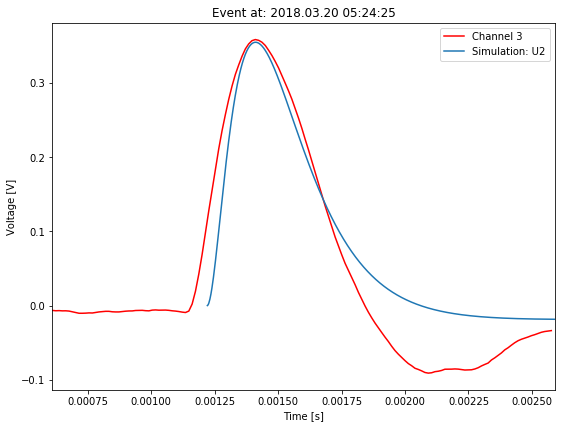

['LeCroyHDO/measurement_1521363115_C1.bytes', 'LeCroyHDO/measurement_1521363115_C2.bytes', 'LeCroyHDO/measurement_1521363115_C3.bytes']


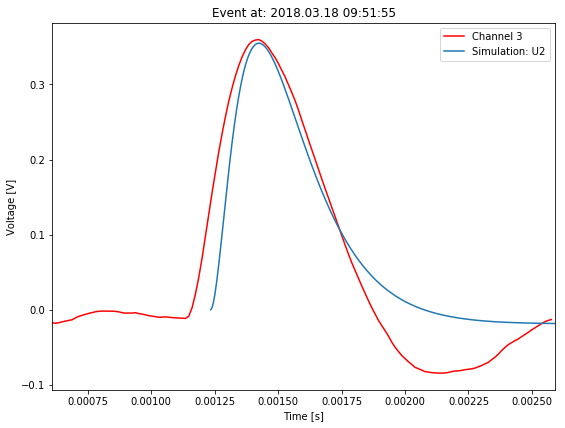

['LeCroyHDO/measurement_1521220451_C1.bytes', 'LeCroyHDO/measurement_1521220451_C2.bytes', 'LeCroyHDO/measurement_1521220451_C3.bytes']


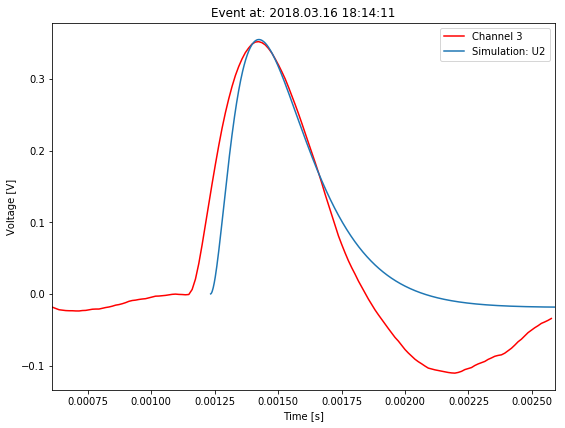

['LeCroyHDO/measurement_1521465073_C1.bytes', 'LeCroyHDO/measurement_1521465073_C2.bytes', 'LeCroyHDO/measurement_1521465073_C3.bytes']


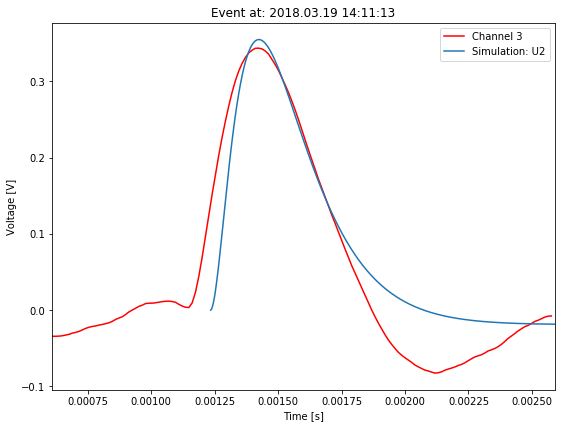

['LeCroyHDO/measurement_1521507670_C1.bytes', 'LeCroyHDO/measurement_1521507670_C2.bytes', 'LeCroyHDO/measurement_1521507670_C3.bytes']


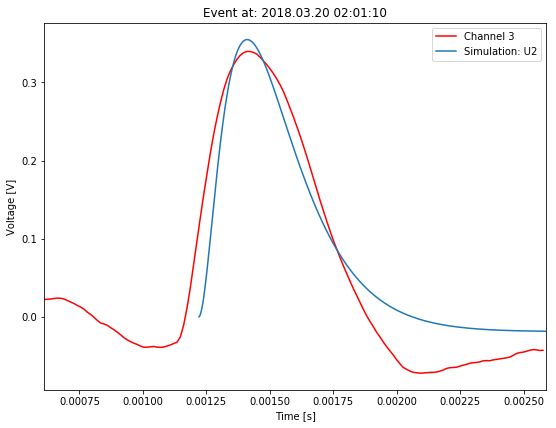

['LeCroyHDO/measurement_1521401047_C1.bytes', 'LeCroyHDO/measurement_1521401047_C2.bytes', 'LeCroyHDO/measurement_1521401047_C3.bytes']


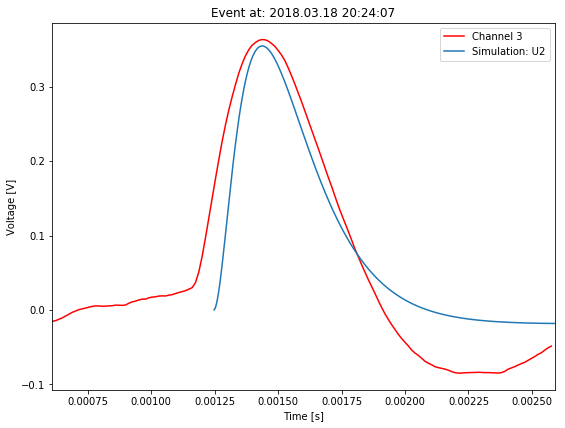

['LeCroyHDO/measurement_1521440941_C1.bytes', 'LeCroyHDO/measurement_1521440941_C2.bytes', 'LeCroyHDO/measurement_1521440941_C3.bytes']


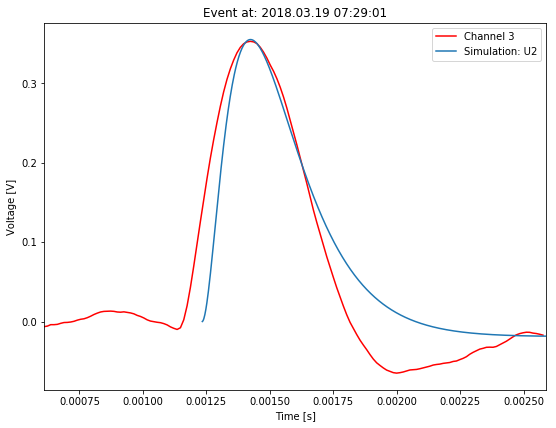

['LeCroyHDO/measurement_1521238881_C1.bytes', 'LeCroyHDO/measurement_1521238881_C2.bytes', 'LeCroyHDO/measurement_1521238881_C3.bytes']


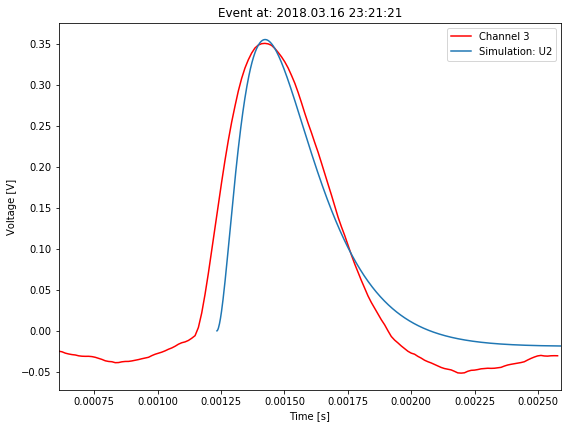

['LeCroyHDO/measurement_1521481144_C1.bytes', 'LeCroyHDO/measurement_1521481144_C2.bytes', 'LeCroyHDO/measurement_1521481144_C3.bytes']


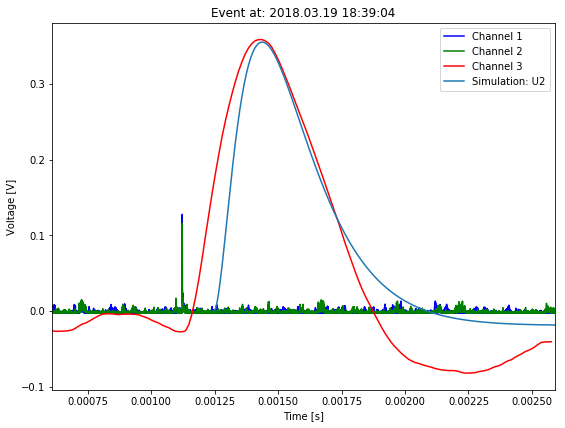

['LeCroyHDO/measurement_1521338856_C1.bytes', 'LeCroyHDO/measurement_1521338856_C2.bytes', 'LeCroyHDO/measurement_1521338856_C3.bytes']


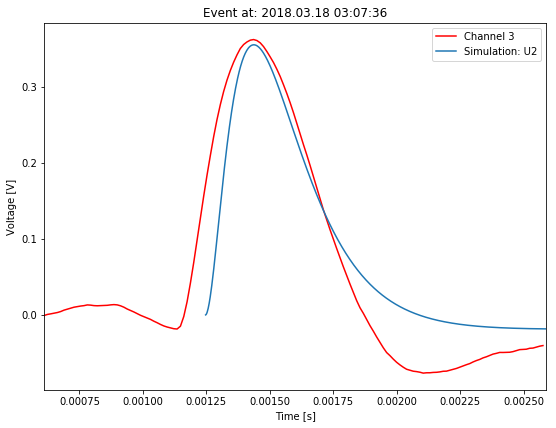

['LeCroyHDO/measurement_1521344693_C1.bytes', 'LeCroyHDO/measurement_1521344693_C2.bytes', 'LeCroyHDO/measurement_1521344693_C3.bytes']


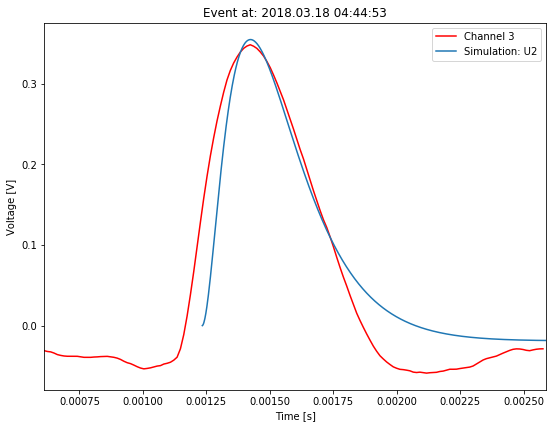

['LeCroyHDO/measurement_1521405647_C1.bytes', 'LeCroyHDO/measurement_1521405647_C2.bytes', 'LeCroyHDO/measurement_1521405647_C3.bytes']


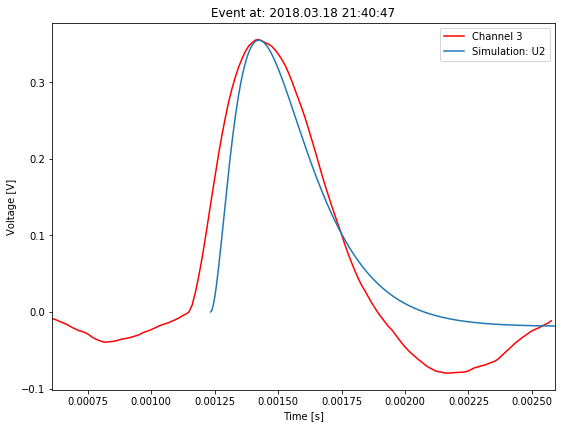

['LeCroyHDO/measurement_1521456010_C1.bytes', 'LeCroyHDO/measurement_1521456010_C2.bytes', 'LeCroyHDO/measurement_1521456010_C3.bytes']


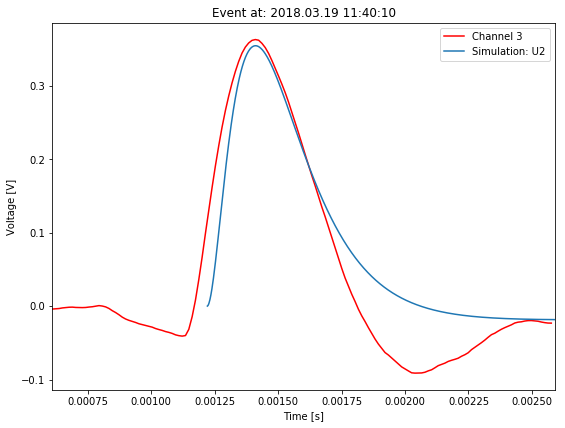

['LeCroyHDO/measurement_1521395418_C1.bytes', 'LeCroyHDO/measurement_1521395418_C2.bytes', 'LeCroyHDO/measurement_1521395418_C3.bytes']


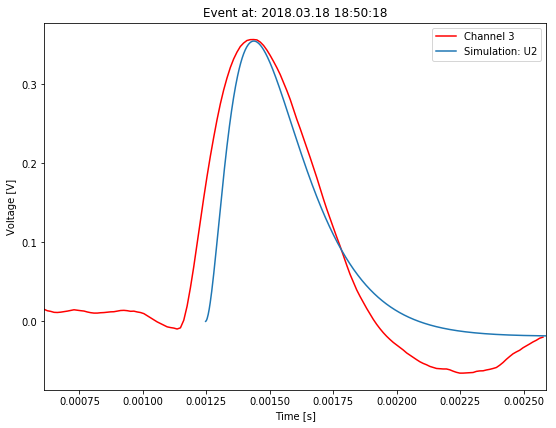

['LeCroyHDO/measurement_1521299956_C1.bytes', 'LeCroyHDO/measurement_1521299956_C2.bytes', 'LeCroyHDO/measurement_1521299956_C3.bytes']


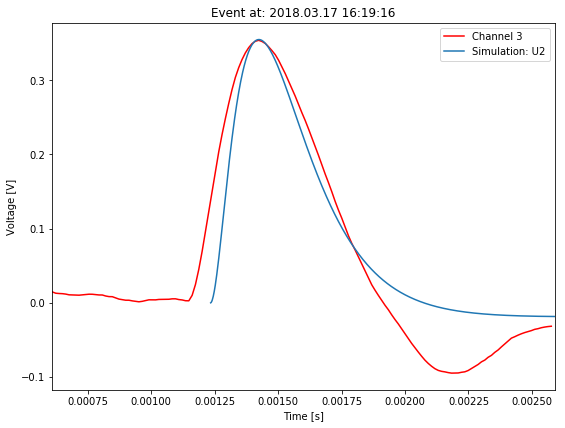

['LeCroyHDO/measurement_1521498801_C1.bytes', 'LeCroyHDO/measurement_1521498801_C2.bytes', 'LeCroyHDO/measurement_1521498801_C3.bytes']


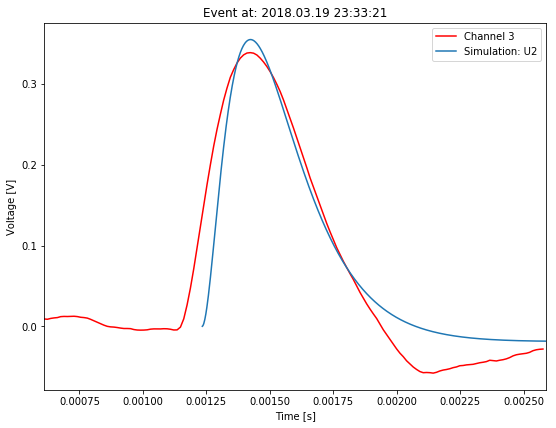

['LeCroyHDO/measurement_1521514321_C1.bytes', 'LeCroyHDO/measurement_1521514321_C2.bytes', 'LeCroyHDO/measurement_1521514321_C3.bytes']


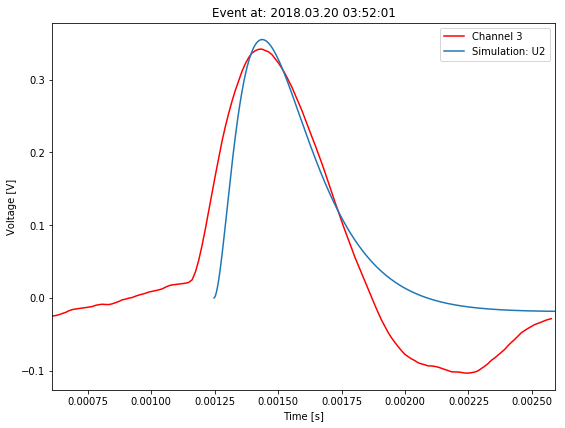

['LeCroyHDO/measurement_1521449432_C1.bytes', 'LeCroyHDO/measurement_1521449432_C2.bytes', 'LeCroyHDO/measurement_1521449432_C3.bytes']


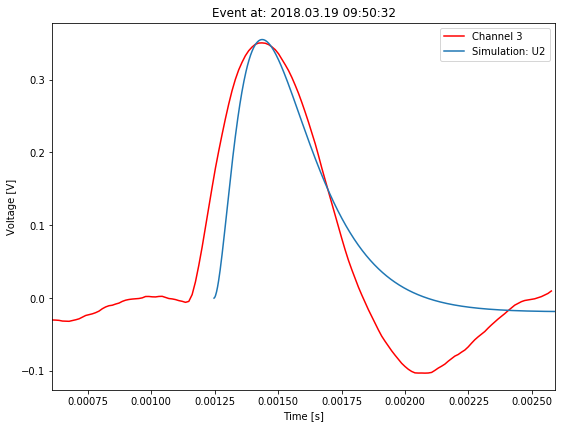

['LeCroyHDO/measurement_1521341603_C1.bytes', 'LeCroyHDO/measurement_1521341603_C2.bytes', 'LeCroyHDO/measurement_1521341603_C3.bytes']


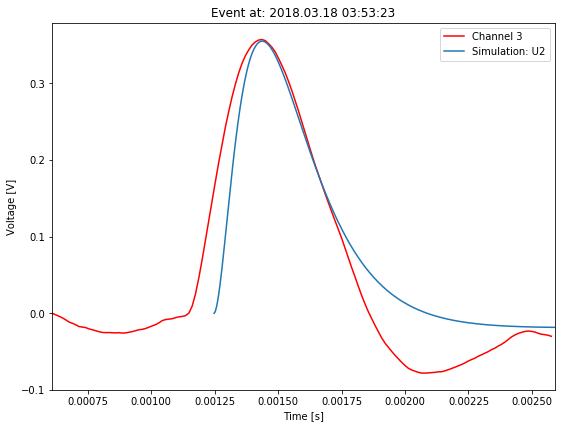

['LeCroyHDO/measurement_1521257379_C1.bytes', 'LeCroyHDO/measurement_1521257379_C2.bytes', 'LeCroyHDO/measurement_1521257379_C3.bytes']


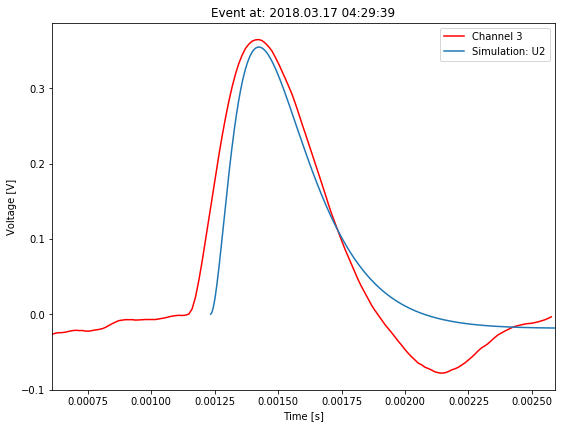

['LeCroyHDO/measurement_1521321208_C1.bytes', 'LeCroyHDO/measurement_1521321208_C2.bytes', 'LeCroyHDO/measurement_1521321208_C3.bytes']


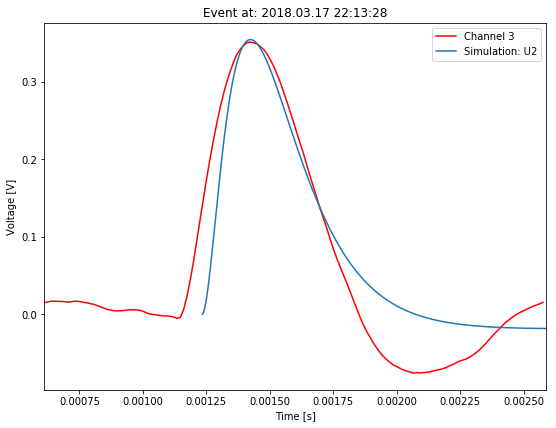

['LeCroyHDO/measurement_1521472837_C1.bytes', 'LeCroyHDO/measurement_1521472837_C2.bytes', 'LeCroyHDO/measurement_1521472837_C3.bytes']


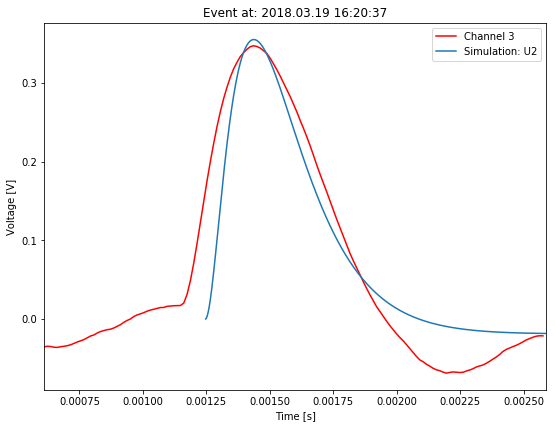

['LeCroyHDO/measurement_1521448610_C1.bytes', 'LeCroyHDO/measurement_1521448610_C2.bytes', 'LeCroyHDO/measurement_1521448610_C3.bytes']


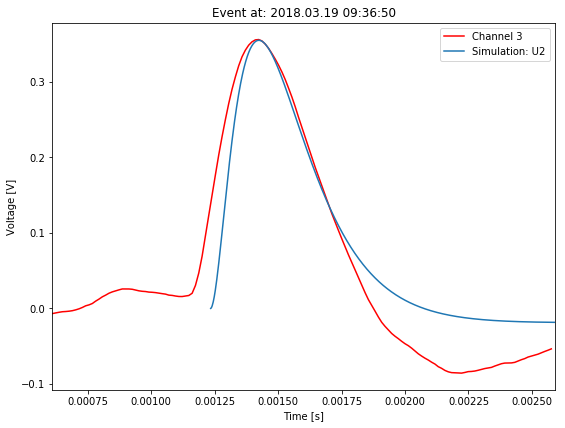

['LeCroyHDO/measurement_1521264926_C1.bytes', 'LeCroyHDO/measurement_1521264926_C2.bytes', 'LeCroyHDO/measurement_1521264926_C3.bytes']


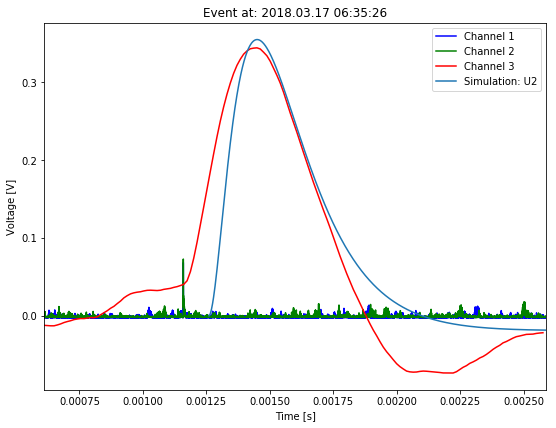

['LeCroyHDO/measurement_1521538529_C1.bytes', 'LeCroyHDO/measurement_1521538529_C2.bytes', 'LeCroyHDO/measurement_1521538529_C3.bytes']


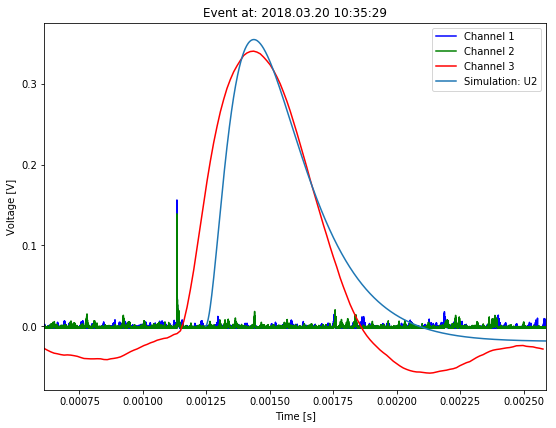

['LeCroyHDO/measurement_1521513174_C1.bytes', 'LeCroyHDO/measurement_1521513174_C2.bytes', 'LeCroyHDO/measurement_1521513174_C3.bytes']


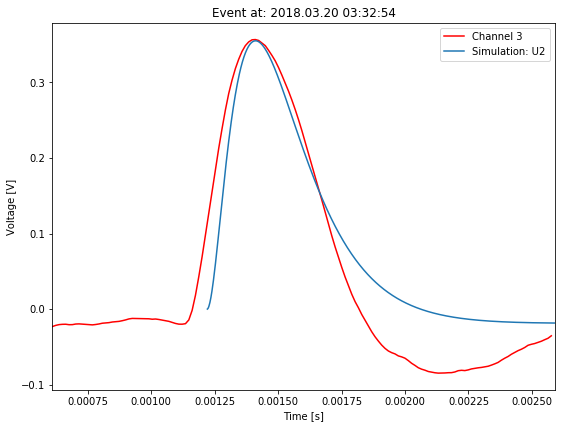

In [75]:
for itter in mask_indices:
    unix_timestamp = WF_data['unixtime'][itter]

    readable_time = datetime.datetime.fromtimestamp(unix_timestamp).strftime('%Y.%m.%d %H:%M:%S')
    WFs = extract_WFs_for_timestamp(unix_timestamp)

    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    
    if WF_data['CosMO coincidence'][itter] == True:
        for i in range(2):
            WFs[i].time, WFs[i].data = avg_reducer(WFs[i].time, WFs[i].data, 32)
            WFs[i].plot_waveform(ax)
    
    WFs[2].time, WFs[2].data = avg_reducer(WFs[2].time, WFs[2].data, 4096*4)
    WFs[2].plot_waveform(ax)
    
    max_times = WFs[2].time[WFs[2].data == WFs[2].data.max()]
    max_mid = np.median(max_times)
    maximum_adjuster = max_mid - np.argmax(m_sim[...,3])*(10**-6) - 95*10**(-6)
    plt.errorbar(maximum_adjuster + m_sim[...,0]*(10**-6), m_sim[...,3]/1000., fmt='-', label='Simulation: U2')
    plt.ylabel("Voltage [V]")
    plt.xlabel("Time [s]")
    
    plt.xlim((WFs[2].time.min(), WFs[2].time.max()))

    plt.legend()
    plt.title('Event at: {}'.format(readable_time))
    #plt.savefig(plot_dir+"size_{}_simulation_overlaid_raw_event_at_{}.pdf".format(size_factor, unix_timestamp))
    
    plt.show()

In [84]:
print(gc.collect(generation=2))

23527


In [103]:
num_wfs_to_plot = 20

times_coince = WF_data['unixtime'][coincidence_and_voltage_mask][:num_wfs_to_plot]
times_no_coince = WF_data['unixtime'][no_coincidence_and_voltage_mask][:num_wfs_to_plot]


#WF_times = [1521424348, 1521513174]
#WF_times = [1521224148, 1521323854, 1521471226, 1521293264, 1521533567, 1521382621, 1521308190, 1521264153, 1521402842, 1521240568, 1521431936, 1521488241, 1521350539, 1521488540, 1521421133, 1521376458, 1521338566, 1521261796, 1521456573, 1521385423, 1521226618, 1521237118, 1521431463, 1521214243, 1521395321, 1521294850, 1521304405, 1521421066, 1521496682, 1521510079, 1521280648, 1521425111, 1521391918, 1521354208, 1521344914, 1521278695, 1521422889, 1521437203, 1521440028, 1521508797, 1521464840, 1521328988, 1521496326, 1521453079, 1521197957, 1521289425, 1521374268, 1521458321, 1521279723, 1521384698, 1521229129, 1521513841, 1521346373, 1521300374, 1521294826, 1521324046, 1521289830, 1521359004, 1521400835, 1521299511, 1521403668, 1521489361, 1521507764, 1521536968, 1521472883, 1521464906, 1521508017, 1521404140, 1521502446, 1521460340, 1521328179, 1521454383, 1521381319, 1521238692, 1521431654, 1521345721, 1521201462, 1521405640, 1521467699, 1521397873, 1521466197, 1521256146, 1521273377, 1521348983, 1521366377, 1521516640, 1521534132]
WF_times = times_coince

WFs_list = [extract_WFs_for_timestamp(x) for x in WF_times]

x_list = []
smoothed_list = []
diff_1_list = []
diff_2_list = []
diff_3_list = []

for WFs in WFs_list:
    x, y = avg_reducer(WFs[2].time, WFs[2].data, 4096*4)
    x_list.append(x)
    smoothed_list.append(y)
    grad1 = np.gradient(y)
    grad2 = np.gradient(grad1)
    grad3 = np.gradient(grad2)
    
    diff_1_list.append(grad)
    diff_2_list.append(grad2)
    diff_3_list.append(grad3)

['LeCroyHDO/measurement_1521454458_C1.bytes', 'LeCroyHDO/measurement_1521454458_C2.bytes', 'LeCroyHDO/measurement_1521454458_C3.bytes']
['LeCroyHDO/measurement_1521369960_C1.bytes', 'LeCroyHDO/measurement_1521369960_C2.bytes', 'LeCroyHDO/measurement_1521369960_C3.bytes']
['LeCroyHDO/measurement_1521256419_C1.bytes', 'LeCroyHDO/measurement_1521256419_C2.bytes', 'LeCroyHDO/measurement_1521256419_C3.bytes']
['LeCroyHDO/measurement_1521496925_C1.bytes', 'LeCroyHDO/measurement_1521496925_C2.bytes', 'LeCroyHDO/measurement_1521496925_C3.bytes']
['LeCroyHDO/measurement_1521313416_C1.bytes', 'LeCroyHDO/measurement_1521313416_C2.bytes', 'LeCroyHDO/measurement_1521313416_C3.bytes']
['LeCroyHDO/measurement_1521504911_C1.bytes', 'LeCroyHDO/measurement_1521504911_C2.bytes', 'LeCroyHDO/measurement_1521504911_C3.bytes']
['LeCroyHDO/measurement_1521364107_C1.bytes', 'LeCroyHDO/measurement_1521364107_C2.bytes', 'LeCroyHDO/measurement_1521364107_C3.bytes']
['LeCroyHDO/measurement_1521216921_C1.bytes', 'L

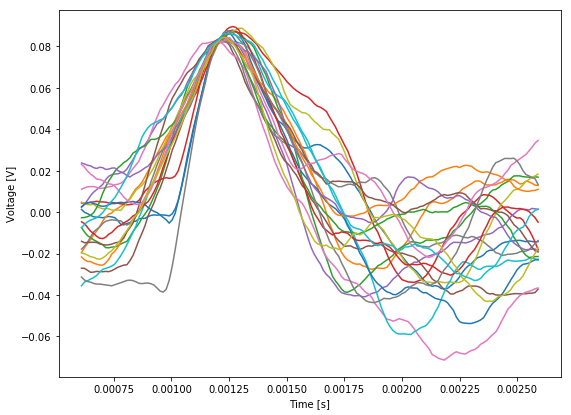

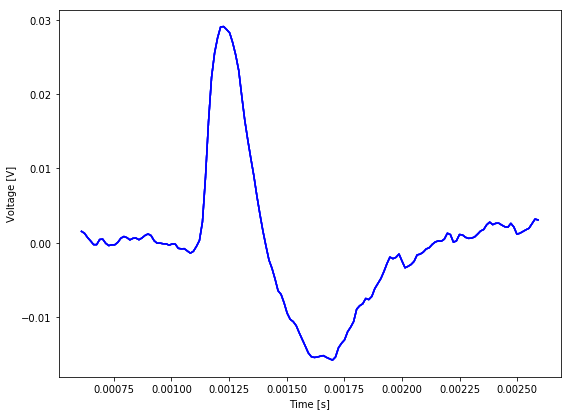

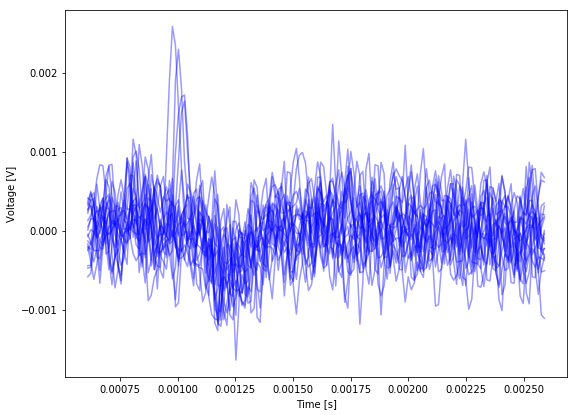

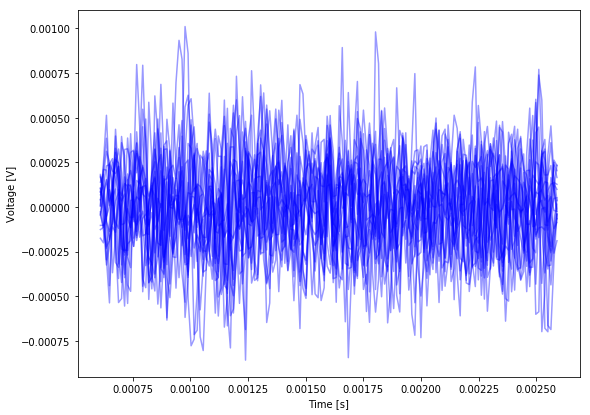

In [104]:
fig, ax = plt.subplots()
fig.set_size_inches(size_factor*9*4./3., size_factor*9)
for i in range(len(x_list)):
    plt.plot(x_list[i], smoothed_list[i], label="Smoothed WF #{}".format(i))

plt.ylabel("Voltage [V]")
plt.xlabel("Time [s]")
#plt.legend()
plt.show()


fig, ax = plt.subplots()
fig.set_size_inches(size_factor*9*4./3., size_factor*9)
for i in range(len(x_list)):
    plt.plot(x_list[i], diff_1_list[i], 'b', alpha=0.2, label="Diff 1 #{}".format(i))

plt.ylabel("Voltage [V]")
plt.xlabel("Time [s]")
#plt.legend()
plt.show()


fig, ax = plt.subplots()
fig.set_size_inches(size_factor*9*4./3., size_factor*9)
for i in range(len(x_list)):
    plt.plot(x_list[i], diff_2_list[i], 'b', alpha=0.4, label="Diff 2 #{}".format(i))

plt.ylabel("Voltage [V]")
plt.xlabel("Time [s]")
#plt.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(size_factor*9*4./3., size_factor*9)
for i in range(len(x_list)):
    plt.plot(x_list[i], diff_3_list[i], 'b', alpha=0.4, label="Diff 3 #{}".format(i))

plt.ylabel("Voltage [V]")
plt.xlabel("Time [s]")
#plt.legend()
plt.show()